# Confidence Distribution Batch Detection (CDBD) Example

This file details how to setup, run, and produce plots for CDBD. This script
monitors the feature "confidence", simulated confidence scores output by a
classifier. Drift occurs in 2018 and persists through 2021. See
src/menelaus/tools/artifacts/README_example_data.txt for more info.

CDBD must be setup and run with batches of data containing 1 variable. 

Plots include: 
- A line plot visualizing test statistics for detection of drift

In [5]:
## Imports ##

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from menelaus.data_drift.cdbd import CDBD

In [6]:
## Setup ##

# Import data
# assumes the script is being run from the root directory.
data = pd.read_csv(
    os.path.join("..", "..", "src", "menelaus", "tools", "artifacts", "example_data.csv"),
    index_col="id",
)

# Set up reference and test batches, using 2007 as reference year
reference = pd.DataFrame(data[data.year == 2007].loc[:, "confidence"])
all_test = data[data.year != 2007]

# Run CDBD
cdbd = CDBD(subsets=8)
cdbd.set_reference(reference)

# Store drift for test statistic plot
detected_drift = []
for year, subset_data in all_test.groupby("year"):
    cdbd.update(pd.DataFrame(subset_data.loc[:, "confidence"]))
    detected_drift.append(cdbd.drift_state)

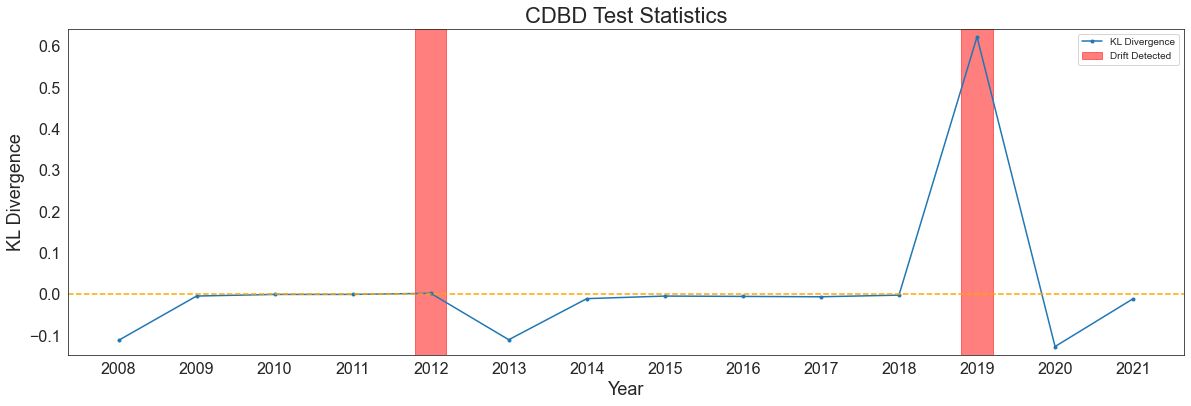

<Figure size 432x288 with 0 Axes>

In [7]:
## Plot Line Graph ##

# Plot Info:
# Drift occurs in 2018 and persists through end of dataset. CDBD identifies drift
# occurring in 2019, one year late. It alerts to a false alarm in 2012.

# Calculate divergences for all years in dataset
years = list(data.year.value_counts().index[1:])
kl_divergence = [
    ep - th for ep, th in zip(cdbd.epsilon_values.values(), cdbd.thresholds.values())
]

# Remove potential infs that arise because of small confidence scores
kl_divergence = [
    x if np.isnan(x) == False and np.isinf(x) == False else 0 for x in kl_divergence
]

# Plot KL Divergence against Year, along with detected drift
plot_data = pd.DataFrame(
    {"Year": years, "KL Divergence": kl_divergence, "Detected Drift": detected_drift}
)
sns.set_style("white")
plt.figure(figsize=(20, 6))
plt.plot("Year", "KL Divergence", data=plot_data, label="KL Divergence", marker=".")
plt.grid(False, axis="x")
plt.xticks(years, fontsize=16)
plt.yticks(fontsize=16)
plt.title("CDBD Test Statistics", fontsize=22)
plt.ylabel("KL Divergence", fontsize=18)
plt.xlabel("Year", fontsize=18)
plt.ylim([min(kl_divergence) - 0.02, max(kl_divergence) + 0.02])
for _, t in enumerate(plot_data.loc[plot_data["Detected Drift"] == "drift"]["Year"]):
    plt.axvspan(
        t - 0.2, t + 0.2, alpha=0.5, color="red", label=("Drift Detected" if _ == 0 else None)
    )
plt.legend()
plt.axhline(y=0, color="orange", linestyle="dashed")

plt.show()
plt.savefig("example_CDBD_test_statistics.png")